In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

## Data Collection 

In [2]:
df1=pd.read_csv('CEDP Jira 2021-01-01--2021-03-25.csv')
df2=pd.read_csv('CEDP Jira 2021-03-25--2021-05-31.csv')
df3=pd.read_csv('CEDP Jira 2021-06-01--2021-08-15.csv')
df4=pd.read_csv('CEDP Jira 2021-08-16--2021-10-25 .csv')
df5=pd.read_csv('CEDP Jira 2021-10-26--2021-12-03.csv')
df6=pd.read_csv('CEDP Jira 2021-12-04--2021-12-31.csv')

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)

(997, 329)
(1000, 341)
(963, 350)
(963, 312)
(529, 294)
(244, 299)


In [3]:
df1.columns

Index(['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Status',
       'Project key', 'Project name', 'Project type', 'Project lead',
       'Project description',
       ...
       'Comment.57', 'Comment.58', 'Comment.59', 'Comment.60', 'Comment.61',
       'Comment.62', 'Comment.63', 'Comment.64', 'Comment.65', 'Comment.66'],
      dtype='object', length=329)

In [4]:
cols_required=['Summary','Issue Type','Assignee','Component/s','Labels','Description']
df1=df1[cols_required]
df2=df2[cols_required]
df3=df3[cols_required]
df4=df4[cols_required]
df5=df5[cols_required]
df6=df6[cols_required]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)

(997, 6)
(1000, 6)
(963, 6)
(963, 6)
(529, 6)
(244, 6)


In [5]:
df_ticket=pd.concat([df1,df2,df3,df4,df5,df6],ignore_index=True)
print('Shape of dataframe : ',df_ticket.shape)

# Showing dataset hiding one columns 'assignee' as it contains personal ID , that is like personal information  
df_ticket.loc[:,df_ticket.columns!='Assignee'].head()

Shape of dataframe :  (4696, 6)


,Summary,Issue Type,Component/s,Labels,Description
0,Deadlock on table view,Incident,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...
1,One ERDM table missing GSA and COS files,Incident,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...
2,Requesting Read Access to the CloudOps COS ins...,Service Request,CEDP Cloud operations,NaN,"Hi, I am part of the DataOps team and requesti..."
3,Requesting access to CloudOps Bucket for DataO...,Service Request,CEDP Cloud operations,NaN,Requesting access to the CloudOps bucket for t...
4,Need a DB2 instance for ERDM on production acc...,Service Request,CEDP Cloud operations,NaN,account 2097266 CEDP - Cloud Compute Prod\r\nR...


In [6]:
# Getting data with personal ID and working team name ID belongs to, data can't be displayed as it is personal informtaion
Members_AssigneeTeam=pd.read_csv('Members_AssigneeTeam.csv')

Members_AssigneeTeam.drop(columns=['Unnamed: 0'],inplace=True)
print('Working Assignee team names in support project - \n',Members_AssigneeTeam.columns)

Working Assignee team names in support project - 
 Index(['Leader', 'L1', 'L2', 'Governance', 'Datastage', 'CloudOps', 'Infra',
       'Cp4d', 'K8', 'ERDM', 'Gov_Kyndryl', 'DataDiscovery', 'Others'],
      dtype='object')


In [7]:
df_ticket.rename(columns={'Issue Type':'Issue_Type'},inplace=True)
df_ticket.columns

Index(['Summary', 'Issue_Type', 'Assignee', 'Component/s', 'Labels',
       'Description'],
      dtype='object')

In [8]:
df_ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696 entries, 0 to 4695
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Summary      4696 non-null   object
 1   Issue_Type   4696 non-null   object
 2   Assignee     4696 non-null   object
 3   Component/s  4683 non-null   object
 4   Labels       3876 non-null   object
 5   Description  4355 non-null   object
dtypes: object(6)
memory usage: 220.2+ KB


###### So, here all columns are object type, means string type 

## Data preprocessing

### Missing value handling 

In [9]:
print(df_ticket.isnull().sum())
print('************')
print(df_ticket.isnull().mean()*100)

Summary          0
Issue_Type       0
Assignee         0
Component/s     13
Labels         820
Description    341
dtype: int64
************
Summary         0.000000
Issue_Type      0.000000
Assignee        0.000000
Component/s     0.276831
Labels         17.461670
Description     7.261499
dtype: float64


In [10]:
df_ticket[df_ticket.Labels.isnull()]['Component/s'].value_counts()

CEDP Cloud operations                      812
Catalog a Database on DataStage Request      2
CEDP Access Request                          1
DB2W Access Request                          1
CEDP Learning Portfolio                      1
Functional ID Access Request                 1
Name: Component/s, dtype: int64

In [11]:
df_ticket[df_ticket['Component/s']=='CEDP Cloud operations'].isnull().sum()

Summary          0
Issue_Type       0
Assignee         0
Component/s      0
Labels         812
Description     52
dtype: int64

#### So, out of 820 Label missing , 812 is for component 'CEDP Cloud operations'

In [12]:
df_ticket[df_ticket['Component/s']=='CEDP Cloud operations']['Labels'].value_counts()

access                338
COS                    86
Bluefringe             46
NewCo                  40
kyndryl                31
DB2                    15
DB2WoC                 14
Kubernetes             12
firewall               11
logdna                 11
Access                  7
Support_bot             6
postgres                6
DB2W                    5
SQL_Query               5
redis                   4
Billing                 4
k8s                     4
openshift               4
Watson_Studio           4
Non_Support             4
Container_Registry      3
ElasticSearch           3
AppID                   3
kubernetes              3
CICD                    3
sysdig                  2
Cloudant                2
Kafka                   2
DB2WOC                  2
Automation              1
DataStage               1
support                 1
acess                   1
Namespaces              1
pvc                     1
cr                      1
toolchain               1
VFA         

In [13]:
Srs_LblNanCmpntNtCld=df_ticket[~(df_ticket['Component/s']=='CEDP Cloud operations')]['Labels'].isnull()
indxs_LblNanCmpntNtCld=Srs_LblNanCmpntNtCld[Srs_LblNanCmpntNtCld].index
indxs_LblNanCmpntNtCld

Int64Index([668, 1066, 1067, 1583, 1744, 2570, 2814, 3506], dtype='int64')

In [14]:
df_ticket.loc[indxs_LblNanCmpntNtCld]['Component/s']

668                         CEDP Access Request
1066    Catalog a Database on DataStage Request
1067    Catalog a Database on DataStage Request
1583                                        NaN
1744                                        NaN
2570                        DB2W Access Request
2814                    CEDP Learning Portfolio
3506               Functional ID Access Request
Name: Component/s, dtype: object

In [15]:
# Manually checked correct Label that should be, for those missing labels and imputed 

df_ticket.loc[668]['Labels']='Access'
df_ticket.loc[1066]['Labels']='On-Boarding'
df_ticket.loc[1067]['Labels']='On-Boarding'
df_ticket.loc[2570]['Labels']='Access'
df_ticket.loc[2814]['Labels']='Access'
df_ticket.loc[3506]['Labels']='Access'

#Just checking one ,whether it's done correctly

print(df_ticket.loc[668]['Labels'])

Access


In [16]:
df_ticket.shape

(4696, 6)

In [17]:
df_ticket[df_ticket['Labels'].isnull()]['Component/s'].value_counts()

CEDP Cloud operations    812
Name: Component/s, dtype: int64

In [18]:
df_ticket[df_ticket['Labels'].isnull()]['Component/s'].unique()

array(['CEDP Cloud operations', nan], dtype=object)

#### So, now all records having missing label is for Component 'CEDP Cloud operations', so we can impute missing label by new label 'CloudOther'

In [19]:
df_ticket.Labels.fillna('CloudOther',inplace=True)

In [20]:
df_ticket.isnull().sum()

Summary          0
Issue_Type       0
Assignee         0
Component/s     13
Labels           0
Description    341
dtype: int64

In [21]:
df_ticket[df_ticket['Component/s'].isnull()]['Labels'].unique()

array(['Question', 'Support_bot', 'CloudOther', 'Non_Support', 'Access'],
      dtype=object)

##### from labels for records having missing component, it is not possible to get component correctly as suggested by subject expert 

In [22]:
# Dropping all records having missing Component/s value

df_ticket.dropna(subset=['Component/s'],inplace=True)

print(df_ticket.shape)
df_ticket.isnull().sum()

(4683, 6)


Summary          0
Issue_Type       0
Assignee         0
Component/s      0
Labels           0
Description    341
dtype: int64

In [23]:
# Filling missing Description by string 'NonProvided'

df_ticket['Description'].fillna('NonProvided',inplace=True)

df_ticket.isnull().sum()

Summary        0
Issue_Type     0
Assignee       0
Component/s    0
Labels         0
Description    0
dtype: int64

In [24]:
# Reseting index as index may not be consecutive because of some record drop
df_ticket.reset_index(drop=True,inplace=True)

In [25]:
df_ticket['AssigneeTeam']=pd.Series([])

C:\Users\KRISHN~1\AppData\Local\Temp/ipykernel_8980/100560177.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ticket['AssigneeTeam']=pd.Series([])


In [26]:
# Getting AssigneeTeam name from individual ID of Assignee , as for a particular type of ticket,this is required because individual assignee may change with time but AssigneeTeam name will not 

for indx in range(df_ticket.shape[0]):
    for colId in range(len(Members_AssigneeTeam.columns)):
        if df_ticket.Assignee[indx] in list(Members_AssigneeTeam.iloc[:,colId]):
            df_ticket.AssigneeTeam[indx]=(Members_AssigneeTeam.columns[colId])

C:\Users\KRISHN~1\AppData\Local\Temp/ipykernel_8980/1485083427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket.AssigneeTeam[indx]=(Members_AssigneeTeam.columns[colId])
C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
df_ticket.head(2)

,Summary,Issue_Type,Assignee,Component/s,Labels,Description,AssigneeTeam
0,Deadlock on table view,Incident,manimoha@in.ibm.com,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,L1
1,One ERDM table missing GSA and COS files,Incident,vivekpan@in.ibm.com,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...,ERDM


In [28]:
df_ticket.AssigneeTeam.unique()   # It confirms Assignee teams mapping is done correctly

array(['L1', 'ERDM', 'CloudOps', 'Governance', 'L2', 'Datastage', 'Infra',
       'DataDiscovery', 'Others', 'K8', 'Cp4d', 'Leader', 'Gov_Kyndryl'],
      dtype=object)

In [29]:
df_ticket.drop(columns=['Assignee'],inplace=True)
df_ticket.head(2)

,Summary,Issue_Type,Component/s,Labels,Description,AssigneeTeam
0,Deadlock on table view,Incident,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,L1
1,One ERDM table missing GSA and COS files,Incident,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...,ERDM


C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Assignee Team')

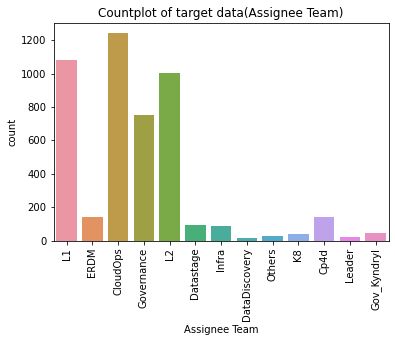

In [30]:
sns.countplot(df_ticket.AssigneeTeam)
plt.xticks(rotation=90)
plt.title('Countplot of target data(Assignee Team)')
plt.xlabel('Assignee Team')

##### from above diagram , it is clear that this is imbalanced data, so over sampling to be performed

In [31]:
df_ticket.columns

Index(['Summary', 'Issue_Type', 'Component/s', 'Labels', 'Description',
       'AssigneeTeam'],
      dtype='object')

In [32]:
## Creating a dictionary for converting string value of AssigneeTeam to numerical value 

dict_AssigneeTeam={}
for k in range(len(Members_AssigneeTeam.columns)):
     dict_AssigneeTeam[Members_AssigneeTeam.columns[k]]=k

dict_AssigneeTeam

{'Leader': 0,
 'L1': 1,
 'L2': 2,
 'Governance': 3,
 'Datastage': 4,
 'CloudOps': 5,
 'Infra': 6,
 'Cp4d': 7,
 'K8': 8,
 'ERDM': 9,
 'Gov_Kyndryl': 10,
 'DataDiscovery': 11,
 'Others': 12}

In [33]:
df_ticket.AssigneeTeam=df_ticket.AssigneeTeam.map(dict_AssigneeTeam)
df_ticket

,Summary,Issue_Type,Component/s,Labels,Description,AssigneeTeam
0,Deadlock on table view,Incident,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,1
1,One ERDM table missing GSA and COS files,Incident,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...,9
2,Requesting Read Access to the CloudOps COS ins...,Service Request,CEDP Cloud operations,CloudOther,"Hi, I am part of the DataOps team and requesti...",1
3,Requesting access to CloudOps Bucket for DataO...,Service Request,CEDP Cloud operations,CloudOther,Requesting access to the CloudOps bucket for t...,5
4,Need a DB2 instance for ERDM on production acc...,Service Request,CEDP Cloud operations,CloudOther,account 2097266 CEDP - Cloud Compute Prod\r\nR...,5
...,...,...,...,...,...,...
4678,Access to projects Jira@IBM-IERP-Billing-Team ...,Service Request,"Jira Access, Projects & Configs",JiraAccess,"Hello Team,\r\nPlease, grant me access to proj...",2
4679,data is being masked from CRMED source to DMT COS,Service Request,CEDP Cloud operations,CloudOther,data is being masked on pulling data from CRME...,1
4680,Add my id to datastage engine nodes please.,Service Request,Other Access Request,Access,"Hi team, \r\nCan you add my id ""rajesh.singh11...",2
4681,Catalog DB and open flows for FINDGOE and ICI ...,Service Request,Other Access Request,Access,Please catalogue DB for ingestion through DMT ...,4


In [34]:
print(len(df_ticket['Issue_Type'].unique()))
print(len(df_ticket['Component/s'].unique()))
print(len(df_ticket['Labels'].unique()))

4
38
86


##### Here too much category there in component and Labels, so one hot encoding can't be used 

In [35]:
pd.set_option("display.max_rows", None)

print('Count of unique Label : ',len(df_ticket['Labels'].unique()))
print(df_ticket['Labels'].value_counts(sort=True))


Count of unique Label :  86
Access                    1450
CloudOther                 812
access                     338
JiraAccess                 197
DataStage                  182
Watson_Studio              166
User_Zones_BigSQL/HDFS     158
ERDM                       150
GitHub_access              127
On-Boarding                105
COS                         86
Other_CEDP                  86
TableManagement             80
Question                    77
DB2W                        75
Non_Support                 63
Kubernetes                  49
Bluefringe                  46
NewCo                       40
kyndryl                     32
JiraSupport                 28
Support_bot                 26
Ingestion                   24
IGC                         20
CEDP_Portal                 19
Drop_Zone                   18
User_to_Resolve             18
DB2WoC                      16
DB2                         15
Db2WoCAccess                13
logdna                      11
Infrastruct

In [36]:
valCount_Labels=df_ticket['Labels'].value_counts()
label_valCountl4_lbl=valCount_Labels[valCount_Labels<=4].index
label_valCountl4_lbl

Index(['Billing', 'openshift', 'redis', 'k8s', 'kubernetes', 'Db2WHoCAccess',
       'Bluegroups', 'AppID', 'ElasticSearch', 'CICD', 'Container_Registry',
       'DB2WOC', 'Jira_Access', 'Cloudant', 'Datastage', 'Kafka', 'Jira',
       'DataDiscovery', 'AccessHub', 'Access,', 'sysdig', 'pvc', 'acess',
       'Namespaces', 'Test', 'IA', 'Automation', 'support', 'datastage',
       'toolchain', 'CP4D', 'Data-Discovery', 'VFA', 'mongodb', 'Service_ID',
       'VM', 'EventStreams', 'Audit', 'cr', 'Drop_Zone_HDFS',
       'Secrets_Manager', 'Watson_Discovery', 'Watson_Open_Scale',
       'Test_ticket', 'Artifactory', 'Monorepo'],
      dtype='object')

In [37]:
# Creating dictionary for label mapping 

dict_label_map={'kubernetes':'Kubernetes','k8s':'Kubernetes','Db2WHoCAccess':'Db2WoCAccess','AppID':'CloudSpecific','Container_Registry':'CloudSpecific','CICD':'CloudSpecific','ElasticSearch':'Lbl_others',
       'sysdig':'CloudSpecific','Jira_Access':'JiraAccess','AccessHub':'Lbl_others','Cloudant':'CloudSpecific','Datastage':'DataStage',
       'Access,':'Access','DB2WOC':'DB2W','Jira':'JiraSupport','DataDiscovery':'Lbl_others','datastage':'DataStage','Service_ID':'CloudSpecific',
       'Data-Discovery':'Lbl_others','cr':'CloudSpecific', 'Automation':'CloudSpecific','IA':'Lbl_others','Namespaces':'CloudSpecific','logdna':'CloudSpecific',
       'Drop_Zone_HDFS':'Drop_Zone','Test_ticket':'Lbl_others','EventStreams':'CloudSpecific','CP4D':'Watson_Studio','VFA':'CloudSpecific',
       'Artifactory':'Access','pvc':'CloudSpecific','Watson_Discovery':'CloudSpecific','support':'Lbl_others','Monorepo':'GitHub_access',
       'mongodb':'Lbl_others','Audit':'Lbl_others','VM':'CloudSpecific','acess':'Access','Test':'Lbl_others','Secrets_Manager':'CloudSpecific',
       'toolchain':'CloudSpecific','Watson_Open_Scale':'CloudSpecific','SQL_Query':'CloudSpecific','postgres':'CloudSpecific','firewall':'CloudSpecific',
        'openshift':'CloudSpecific','COS':'CloudSpecific','Bluefringe':'CloudSpecific','redis':'CloudSpecific','Billing':'CloudSpecific'}

dict_label_map

{'kubernetes': 'Kubernetes',
 'k8s': 'Kubernetes',
 'Db2WHoCAccess': 'Db2WoCAccess',
 'AppID': 'CloudSpecific',
 'Container_Registry': 'CloudSpecific',
 'CICD': 'CloudSpecific',
 'ElasticSearch': 'Lbl_others',
 'sysdig': 'CloudSpecific',
 'Jira_Access': 'JiraAccess',
 'AccessHub': 'Lbl_others',
 'Cloudant': 'CloudSpecific',
 'Datastage': 'DataStage',
 'Access,': 'Access',
 'DB2WOC': 'DB2W',
 'Jira': 'JiraSupport',
 'DataDiscovery': 'Lbl_others',
 'datastage': 'DataStage',
 'Service_ID': 'CloudSpecific',
 'Data-Discovery': 'Lbl_others',
 'cr': 'CloudSpecific',
 'Automation': 'CloudSpecific',
 'IA': 'Lbl_others',
 'Namespaces': 'CloudSpecific',
 'logdna': 'CloudSpecific',
 'Drop_Zone_HDFS': 'Drop_Zone',
 'Test_ticket': 'Lbl_others',
 'EventStreams': 'CloudSpecific',
 'CP4D': 'Watson_Studio',
 'VFA': 'CloudSpecific',
 'Artifactory': 'Access',
 'pvc': 'CloudSpecific',
 'Watson_Discovery': 'CloudSpecific',
 'support': 'Lbl_others',
 'Monorepo': 'GitHub_access',
 'mongodb': 'Lbl_others',
 'A

In [38]:
# Replace some Labels with correct Labels

df_ticket.Labels.replace(dict_label_map,inplace=True)

print('Count of unique Label now : ',len(df_ticket.Labels.unique()))
df_ticket.Labels.unique()

Count of unique Label now :  38


array(['User_Zones_BigSQL/HDFS', 'ERDM', 'CloudOther', 'API', 'Access',
       'DataStage', 'User_to_Resolve', 'GitHub_access', 'Ingestion',
       'TableManagement', 'IGC', 'JiraSupport', 'Other_CEDP',
       'CEDP_Portal', 'Question', 'Non_Support', 'On-Boarding',
       'JiraAccess', 'DB2W', 'Watson_Studio', 'Support_bot', 'Kubernetes',
       'Bluegroups', 'Infrastructure', 'Drop_Zone', 'Non_CEDP',
       'Db2WoCAccess', 'DAM', 'Lbl_others', 'JIRA', 'NewCo', 'DB2WoC',
       'catalog-sync-issue', 'access', 'CloudSpecific', 'DB2', 'kyndryl',
       'Kafka'], dtype=object)

In [39]:
pd.set_option("display.max_rows", None)

print('Count of unique Component : ',len(df_ticket['Component/s'].unique()))
print(df_ticket['Component/s'].value_counts(sort=True))

Count of unique Component :  38
CEDP Cloud operations                      1510
Other Access Request                        639
CEDP Access Request                         319
Jira Access, Projects & Configs             235
Watson Studio Access                        212
DataStage Issue                             194
User Zones - BigSQL HDFS Issue              177
Watson Studio                               173
DataStage Access Request                    171
Mono Repo Access                            130
Other CEDP Issue                            118
Catalog a Database on DataStage Request     110
Table Management Request                     85
ERDM Issue                                   75
ERDM Requirement Request                     75
DB2W (DASHDB) Issue                          73
DB2W Access Request                          68
Functional ID Access Request                 64
Questions                                    60
Co-Creation K8s Issue                        38
CEDP Ing

In [40]:
# Creating dictionary for Component mapping

dict_component_map={'Open Stack Issue':'Component_others','Data Discovery Tool Issue':'Component_others','Data Studio Issue':'Component_others','DB2Woc Access Request':'DB2W Access Request',
                   'Access Control':'Other Access Request','CEDP Learning Portfolio':'Component_others','DB2 WoC DashDB Issue':'DB2W (DASHDB) Issue',
                   'BlueGroup Access Issue':'Other Access Request','DAM Issue':'Component_others','IA / Data Quality Issue':'Component_others',
                   'Data Discovery Tool Requirement':'Component_others'}

dict_component_map

{'Open Stack Issue': 'Component_others',
 'Data Discovery Tool Issue': 'Component_others',
 'Data Studio Issue': 'Component_others',
 'DB2Woc Access Request': 'DB2W Access Request',
 'Access Control': 'Other Access Request',
 'CEDP Learning Portfolio': 'Component_others',
 'DB2 WoC DashDB Issue': 'DB2W (DASHDB) Issue',
 'BlueGroup Access Issue': 'Other Access Request',
 'DAM Issue': 'Component_others',
 'IA / Data Quality Issue': 'Component_others',
 'Data Discovery Tool Requirement': 'Component_others'}

In [41]:
# Replace some Components with correct Component

df_ticket['Component/s'].replace(dict_component_map,inplace=True)

print('Count of unique Component now : ',len(df_ticket['Component/s'].unique()))
df_ticket['Component/s'].unique()

Count of unique Component now :  28


array(['User Zones - BigSQL HDFS Issue', 'ERDM Issue',
       'CEDP Cloud operations', 'API Issue',
       'Functional ID Access Request', 'DataStage Issue',
       'DataStage Access Request', 'Other Access Request',
       'CEDP Access Request', 'ERDM Requirement Request',
       'Mono Repo Access', 'CEDP Ingestion Issue',
       'Table Management Request', 'Watson Studio Access', 'IGC Issue',
       'Jira Access, Projects & Configs', 'Other CEDP Issue',
       'CEDP Portal', 'Component_others',
       'Catalog a Database on DataStage Request', 'DB2W (DASHDB) Issue',
       'Watson Studio', 'DB2W Access Request', 'Questions',
       'Infrastructure Updates Request', 'Co-Creation K8s Issue',
       'Drop Zone Issue', 'Jira Service Desk Issue'], dtype=object)

In [42]:
df_ticket['Issue_Type'].value_counts()

Service Request                   3584
Incident                           975
Question                            80
Service Request with Approvals      44
Name: Issue_Type, dtype: int64

In [43]:
OneHtEncd_IssueType=pd.get_dummies(df_ticket['Issue_Type'],drop_first=True,prefix='Issue_Type')
OneHtEncd_IssueType.head()

,Issue_Type_Question,Issue_Type_Service Request,Issue_Type_Service Request with Approvals
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0


In [44]:
df_ticket=pd.concat([df_ticket,OneHtEncd_IssueType],axis='columns')
df_ticket.head()

,Summary,Issue_Type,Component/s,Labels,Description,AssigneeTeam,Issue_Type_Question,Issue_Type_Service Request,Issue_Type_Service Request with Approvals
0,Deadlock on table view,Incident,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,1,0,0,0
1,One ERDM table missing GSA and COS files,Incident,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...,9,0,0,0
2,Requesting Read Access to the CloudOps COS ins...,Service Request,CEDP Cloud operations,CloudOther,"Hi, I am part of the DataOps team and requesti...",1,0,1,0
3,Requesting access to CloudOps Bucket for DataO...,Service Request,CEDP Cloud operations,CloudOther,Requesting access to the CloudOps bucket for t...,5,0,1,0
4,Need a DB2 instance for ERDM on production acc...,Service Request,CEDP Cloud operations,CloudOther,account 2097266 CEDP - Cloud Compute Prod\r\nR...,5,0,1,0


In [45]:
df_ticket.drop(columns=['Issue_Type'],inplace=True)
df_ticket.rename(columns={'Issue_Type_Service Request':'Issue_Type_Service_Request','Issue_Type_Service Request with Approvals':'Issue_Type_Service_Request_Approvals'},inplace=True)
df_ticket.head()

,Summary,Component/s,Labels,Description,AssigneeTeam,Issue_Type_Question,Issue_Type_Service_Request,Issue_Type_Service_Request_Approvals
0,Deadlock on table view,User Zones - BigSQL HDFS Issue,User_Zones_BigSQL/HDFS,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,1,0,0,0
1,One ERDM table missing GSA and COS files,ERDM Issue,ERDM,ERDM table REFT_OFFERING_GTM_STATUS is missing...,9,0,0,0
2,Requesting Read Access to the CloudOps COS ins...,CEDP Cloud operations,CloudOther,"Hi, I am part of the DataOps team and requesti...",1,0,1,0
3,Requesting access to CloudOps Bucket for DataO...,CEDP Cloud operations,CloudOther,Requesting access to the CloudOps bucket for t...,5,0,1,0
4,Need a DB2 instance for ERDM on production acc...,CEDP Cloud operations,CloudOther,account 2097266 CEDP - Cloud Compute Prod\r\nR...,5,0,1,0


In [46]:
# label encoding for Label and Component

from sklearn.preprocessing import LabelEncoder
le_Label=LabelEncoder()
le_Component=LabelEncoder()
df_ticket.Labels=le_Label.fit_transform(df_ticket.Labels)
df_ticket['Component/s']=le_Component.fit_transform(df_ticket['Component/s'])

df_ticket.head()

,Summary,Component/s,Labels,Description,AssigneeTeam,Issue_Type_Question,Issue_Type_Service_Request,Issue_Type_Service_Request_Approvals
0,Deadlock on table view,25,32,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,1,0,0,0
1,One ERDM table missing GSA and COS files,13,13,ERDM table REFT_OFFERING_GTM_STATUS is missing...,9,0,0,0
2,Requesting Read Access to the CloudOps COS ins...,2,4,"Hi, I am part of the DataOps team and requesti...",1,0,1,0
3,Requesting access to CloudOps Bucket for DataO...,2,4,Requesting access to the CloudOps bucket for t...,5,0,1,0
4,Need a DB2 instance for ERDM on production acc...,2,4,account 2097266 CEDP - Cloud Compute Prod\r\nR...,5,0,1,0


In [47]:
X=df_ticket[['Summary','Description','Component/s','Labels','Issue_Type_Question','Issue_Type_Service_Request','Issue_Type_Service_Request_Approvals']]
X.head(2)

,Summary,Description,Component/s,Labels,Issue_Type_Question,Issue_Type_Service_Request,Issue_Type_Service_Request_Approvals
0,Deadlock on table view,Hi! deadlock on Landing Zone PIQTELCO_TELCO.CD...,25,32,0,0,0
1,One ERDM table missing GSA and COS files,ERDM table REFT_OFFERING_GTM_STATUS is missing...,13,13,0,0,0


In [48]:
Y=df_ticket['AssigneeTeam']
Y.head(2)

0    1
1    9
Name: AssigneeTeam, dtype: int64

In [49]:
# Joining all columns' value of X 

Text=[]
for i in range(X.shape[0]):
    Text.append(' '.join(str(tx) for tx in X.iloc[i,:]))
    
print(type(Text[0]))
print(Text[0])

<class 'str'>
Deadlock on table view Hi! deadlock on Landing Zone PIQTELCO_TELCO.CDO_TELCO_FINAL_CURRENT_N view avoid us to update it (drop and create it again using a new statement)  25 32 0 0 0


### Text analysis 

In [50]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\KrishnenduGhorui\
[nltk_data]    |     AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to C:\Users\KrishnenduGhor
[nltk_data]    |     ui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to C:\
[nltk_data]    |     Users\KrishnenduGhorui\AppData\Roaming\nltk_data.
[nltk_data]    |     ..
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to 
[nltk_data]    |     C:\Users\KrishnenduGhorui\AppData\Roaming\nltk_da
[nltk_data]    |     ta...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_gr

[nltk_data]    |   Package moses_sample is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to C:\Users\Krishne
[nltk_data]    |     nduGhorui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to C:\Users\KrishnenduG
[nltk_data]    |     horui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to C:\Users\KrishnenduGh
[nltk_data]    |     orui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | Downloading package names to C:\Users\KrishnenduGhoru
[nltk_data]    |     i\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package nombank.1.0 to C:\Users\Krishnend
[nltk_data]    |     uGhorui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nombank.1.0 is already up-to-date!


[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to C:\Users\KrishnenduGho
[nltk_data]    |     rui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to C:\Users\KrishnenduGh
[nltk_data]    |     orui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to C:\Users\Krish
[nltk_data]    |     nenduGhorui\AppData\Roaming\nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to C:\Users\KrishnenduGhorui
[nltk_data]    |     \AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to C:\Users\KrishnenduGhoru
[nltk_data]    |     i\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Down

True

In [51]:
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
from nltk.corpus import stopwords

In [52]:
# text cleaning 

for i in range(X.shape[0]):
    Text[i]=Text[i].lower()
    Text[i]=re.sub('[\r\n]',' ',Text[i])
    Text[i]=re.sub('[^0-9a-zA-Z]',' ',Text[i])
    Text[i]=Text[i].split()
    Text[i]=[lemmatizer.lemmatize(word) for word in Text[i] if word not in set (stopwords.words('english'))]
    Text[i]=' '.join(Text[i])

In [53]:
Text[0]

'deadlock table view hi deadlock landing zone piqtelco telco cdo telco final current n view avoid u update drop create using new statement 25 32 0 0 0'

In [54]:
# Having Tfidf Vectorizer for converting text to numerical value 

from sklearn.feature_extraction.text import TfidfVectorizer
vect_tfidf=TfidfVectorizer()
vect_tfidf.fit(Text)

TfidfVectorizer()

In [55]:
len(Text)
Y.shape

(4683,)

In [56]:
# Splitting whole data set into training and test data

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(Text,Y,train_size=.8,random_state=42)

print(len(x_train),y_train.shape)
print(len(x_test),y_test.shape)

3746 (3746,)
937 (937,)


In [57]:
# Converting train and test data to numeracal (vector) form 

x_train=vect_tfidf.transform(x_train).toarray()
x_test=vect_tfidf.transform(x_test).toarray()

In [58]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
print(x_train)
print(x_test)
print(y_train.head(2))

(3746, 14590) (937, 14590)
(3746,) (937,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2080    2
1309    3
Name: AssigneeTeam, dtype: int64


In [59]:
y_train.value_counts()

5     1006
1      867
2      787
3      580
7      113
9      113
4       78
6       77
10      37
8       33
12      24
0       18
11      13
Name: AssigneeTeam, dtype: int64

##### So, it's imbalanced data 

### Imbalaced data handling 

In [60]:
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=42)
x_train_res,y_train_res=smt.fit_resample(x_train,y_train)

print(x_train_res.shape,y_train_res.shape)

(13078, 14590) (13078,)


C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Assignee')

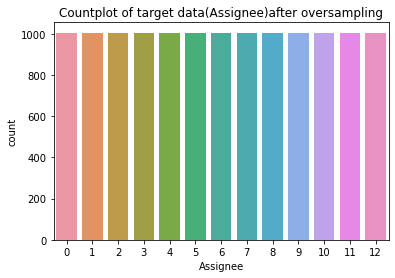

In [61]:
sns.countplot(y_train_res)
plt.title('Countplot of target data(Assignee)after oversampling')
plt.xlabel('Assignee')

In [62]:
print(y_train_res.dtype)
y_train_res.head()

int64


0    2
1    3
2    5
3    1
4    5
Name: AssigneeTeam, dtype: int64

In [63]:
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.svm import SVC

#sample_svc=SVC()
#params={'C':[0.1,0.01,0.001],'kernel':['rbf','poly'],'gamma':[0.9,0.8]}
#rscv=RandomizedSearchCV(estimator=sample_svc,param_distributions=params,cv=5,n_jobs=-1,random_state=42)
#rscv.fit(x_train_res,y_train_res)

In [64]:
#rscv.best_params_
#rscv.best_score_

##### Gaussian Naive bayes algorithm 

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
model_gnb=GaussianNB()
model_mnb=MultinomialNB()
model_svc=SVC(C=0.7,kernel='rbf',gamma=0.9)

In [66]:
#models={'GaussianNB model':model_gnb,'MultinomialNB model':MultinomialNB,'SVC model':model_svc}

In [67]:
#for modelName in models:
  #  print(modelName)
   # model=models[modelName]
   # model.fit(x_train_res,y_train_res)
   # score=model.score(x_test.toarray(),y_test)
   # print('Accuracy score of ',modelName,' is ',score)

In [68]:
from sklearn.naive_bayes import GaussianNB
model_gnb=GaussianNB()
model_gnb.fit(x_train_res,y_train_res)

GaussianNB()

In [69]:
print(model_gnb.score(x_test,y_test))

y_pred_gnb=model_gnb.predict(x_test)
y_pred_gnb

0.48772678762006405


array([ 1,  2,  2,  2,  3,  5,  2,  2,  9,  3,  2,  1,  2,  2,  5,  5,  2,
        3,  1,  3,  4,  1,  2,  6,  5,  6,  2,  2,  2,  6,  3,  3,  5,  2,
        1,  1,  3,  9,  3,  5,  2,  5,  5,  2,  2,  8,  2,  5,  2,  5,  3,
        1,  1,  3,  3,  2,  5,  1,  5,  5,  1,  5,  2,  1,  2,  2,  3,  5,
        5,  3,  1,  5,  9,  7,  2,  3,  2,  2,  3,  4,  1,  3,  1,  2,  2,
        5,  3,  3,  2,  2,  3,  5,  1,  2,  3,  1,  2,  1,  3,  3,  1,  1,
        3,  1,  3,  5,  5,  2,  7,  3,  3,  5,  9,  3,  3,  3,  1,  2,  5,
        3,  8,  5, 10,  4,  2,  4,  3,  1,  5,  3,  2,  5,  2,  3,  5,  3,
        2,  5,  3,  5,  1,  4,  1,  1,  1,  2,  2,  3,  2,  5,  1,  1,  5,
        3,  2,  3,  8,  1,  2,  4,  1,  2,  2,  5,  3,  3,  2,  1,  1,  3,
        9,  2,  2,  5,  4,  3,  7,  1,  3,  2,  1,  1,  3,  2,  5,  2,  5,
        7,  3,  3,  3,  2,  3,  9,  1,  5,  3,  5,  1,  1,  5,  1,  2,  1,
        7,  1,  2,  2,  3,  2,  5,  1,  5,  5,  4,  1,  3,  5,  5,  3,  5,
        3,  3,  5,  3,  5

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.37      0.28      0.32       213
           2       0.50      0.50      0.50       214
           3       0.42      0.49      0.45       169
           4       0.00      0.00      0.00        14
           5       0.68      0.75      0.71       234
           6       0.10      0.18      0.13        11
           7       0.43      0.36      0.39        28
           8       0.12      0.11      0.12         9
           9       0.86      0.62      0.72        29
          10       0.12      0.14      0.13         7
          11       0.00      0.00      0.00         2
          12       1.00      0.25      0.40         4

    accuracy                           0.49       937
   macro avg       0.35      0.28      0.30       937
weighted avg       0.49      0.49      0.49       937



<AxesSubplot:>

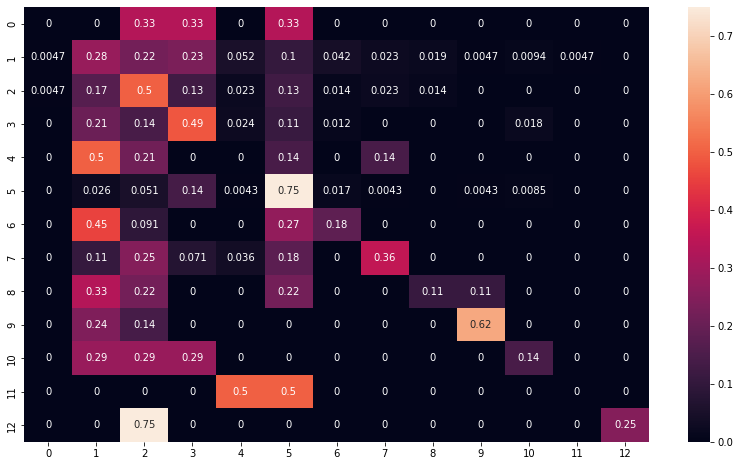

In [70]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

print(classification_report(y_test,y_pred_gnb))

cm_gnb=confusion_matrix(y_test,y_pred_gnb,normalize='true')   # Getting confusion matrix normalized on orginal data value
plt.figure(figsize=(14,8))
sns.heatmap(cm_gnb,annot=True)

In [71]:
# Just seeing how prediction works

print('Original')
print(Text[50])
print(Y[50])
print(Text[82])
print(Y[82])
print('Predicted ',model_gnb.predict(vect_tfidf.transform([Text[50]]).toarray()))
print('Predicted ',model_gnb.predict(vect_tfidf.transform([Text[82]]).toarray()))

Original
error datastage engnode5 hello team detail host ihs iiszprodcedp zc2 ibm com 443 project engnode5 iiszprodcedp zc2 ibm com pz eam reporting job name oh1 emea ibm error message id drop table exists iz enterprise assetmgt report oh1 emea baseline sesdrdb20000i sql command completed successfully rename table iz enterprise assetmgt report oh1 emea baseline sesdr dev report oh1 emea baseline sesdrdb21034e command processed sql statement valid command line processor command sql processing returned sql5105n statement failed big sql component encountered error component receiving error component returning error hive log entry identifier bsl 0 547231ea sqlstate 58040 check log get 2021 03 21 11 35 00 417 error org apache hadoop hive ql driver thread 28 failed execution error return code 1 org apache hadoop hive ql exec ddltask unable alter table new location table iz enterprise assetmgt report oh1 emea baseline sesdr already exists hdfs dc19n1 zc2 ibm com 8020 apps hive warehouse iz en

##### Multinomial Naive bayes algorithm 

In [72]:
from sklearn.naive_bayes import MultinomialNB
model_mnb=MultinomialNB()
model_mnb.fit(x_train_res,y_train_res)

MultinomialNB()

In [73]:
y_pred_mnb=model_mnb.predict(x_test)
y_pred_mnb

array([ 1,  0,  7,  3,  3,  5,  1,  2,  9,  1,  2,  2,  3,  5, 10,  5, 12,
        2,  1,  2,  4, 10,  1,  3,  5,  6,  2,  2,  2,  3,  6,  2,  5,  2,
        7,  1,  3,  9,  3,  5,  2,  5,  5,  1,  4,  2,  3,  5, 10,  5,  3,
        2,  2,  3,  2,  3,  8,  3, 10,  3,  4,  2,  2,  3,  6,  2,  7,  5,
        5,  3,  2,  5,  9,  7,  0,  2,  3,  5,  5,  2,  1,  3,  3,  2,  2,
       12, 10,  2,  7, 10,  3,  5,  7, 10,  3,  1,  5,  3,  3,  1,  1,  1,
       10,  1,  5,  5,  5,  4,  6,  0,  3,  8,  5,  3,  7,  4,  3,  1,  6,
        3,  8,  5,  5,  1,  2,  4,  6,  3,  5,  2,  2,  5,  7,  3,  5,  5,
        1,  0,  1,  5,  6,  4,  1,  2,  4,  2,  2,  5,  2,  3,  7,  9,  5,
        7,  2,  3,  8,  4,  9,  2,  1,  2,  2,  5,  3,  3,  1,  1,  1,  7,
        9,  8,  2,  5, 11,  2,  7,  5,  7,  2,  3,  2,  5,  7,  5,  2,  5,
        7,  1,  3,  2,  2,  2,  9,  1,  6,  5,  5,  4,  6,  5,  3,  2, 12,
        7,  2,  2, 12,  1,  1,  5,  1,  3,  5,  3,  1,  3,  5,  5,  3,  5,
        5,  2,  1,  3,  1

Text(0.5, 1.0, 'Confusion matrix normalized by original target value - multinomialNB - assignee prediction')

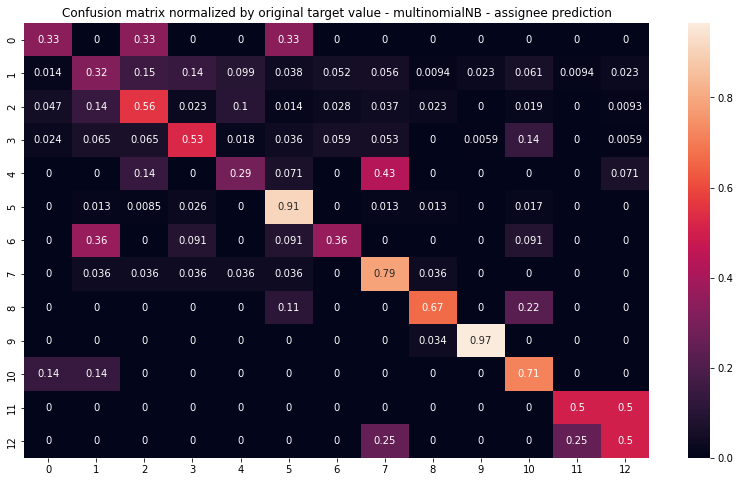

In [74]:
plt.figure(figsize=(14,8))
sns.heatmap(confusion_matrix(y_test,y_pred_mnb,normalize='true'),annot=True)
plt.title('Confusion matrix normalized by original target value - multinomialNB - assignee prediction')

In [75]:
print(classification_report(y_test,y_pred_mnb))

              precision    recall  f1-score   support

           0       0.05      0.33      0.09         3
           1       0.58      0.32      0.41       213
           2       0.70      0.56      0.62       214
           3       0.67      0.53      0.59       169
           4       0.08      0.29      0.12        14
           5       0.91      0.91      0.91       234
           6       0.13      0.36      0.19        11
           7       0.36      0.79      0.49        28
           8       0.33      0.67      0.44         9
           9       0.82      0.97      0.89        29
          10       0.09      0.71      0.17         7
          11       0.25      0.50      0.33         2
          12       0.17      0.50      0.25         4

    accuracy                           0.60       937
   macro avg       0.40      0.57      0.42       937
weighted avg       0.68      0.60      0.62       937



##### SVC algorithm 

In [76]:
#from sklearn.model_selection import RandomizedSearchCV
#sample_svm=SVC()
#params=[{'C':[0.1,0.01,0.001,0.2,0.02,0.3,0.4,0.5],'kernel':['rbf','poly'],'gamma':[0.9,0.8,0.7]}]
#rscv_svc=RandomizedSearchCV(estimator=sample_svm,param_distributions=params,cv=5)
#rscv_svc.fit(x_train_res,y_train_res)

In [77]:
#print(rscv_svc.best_estimator_)
#print(rscv_svc.best_score_)
#rscv_svc.cv_results_

In [78]:
#from sklearn.svm import SVC
#model_svc=SVC(C=0.7,kernel='poly',gamma=0.9)
#model_svc.fit(x_train_res,y_train_res)

In [79]:
#y_pred_svc=model_svc.predict(x_test)
#print(classification_report(y_test,y_pred_svcr))

In [80]:
#plt.figure(figsize=(14,8))
#sns.heatmap(confusion_matrix(y_test,y_pred_svcrbf,normalize='true'),annot=True)
#plt.title('Confusion matrix normalized by original target value - SVC - assignee prediction')

In [81]:
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestClassifier
#sample_rfc=RandomForestClassifier()
#params={'n_estimators':[80,100,150,200],'criterion':['gini','entropy'],'max_depth':[10,12,15,20]}
#rscv_rfc=RandomizedSearchCV(estimator=sample_rfc,param_distributions=params,cv=5)
#rscv_rfc.fit(x_train_res,y_train_res)

In [82]:
#print(rscv_rfc.best_estimator_)
#print(rscv_rfc.best_score_)
#rscv_rfc.cv_results_

#### Random Forest Classifier 

In [83]:
from sklearn.ensemble import RandomForestClassifier 
model_rfc=RandomForestClassifier(n_estimators=80,criterion='entropy',max_depth=20,n_jobs=-1)
model_rfc.fit(x_train_res,y_train_res)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=80,
                       n_jobs=-1)

In [84]:
y_pred_rfc=model_rfc.predict(x_test)

In [85]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.61      0.41      0.49       213
           2       0.64      0.71      0.67       214
           3       0.68      0.63      0.65       169
           4       0.33      0.21      0.26        14
           5       0.79      0.95      0.86       234
           6       0.60      0.27      0.37        11
           7       0.49      0.71      0.58        28
           8       0.71      0.56      0.63         9
           9       0.81      1.00      0.89        29
          10       0.29      0.29      0.29         7
          11       0.29      1.00      0.44         2
          12       1.00      0.25      0.40         4

    accuracy                           0.68       937
   macro avg       0.56      0.54      0.50       937
weighted avg       0.67      0.68      0.66       937



Text(0.5, 1.0, 'Confusion matrix normalized by original target value - SVC - assignee prediction')

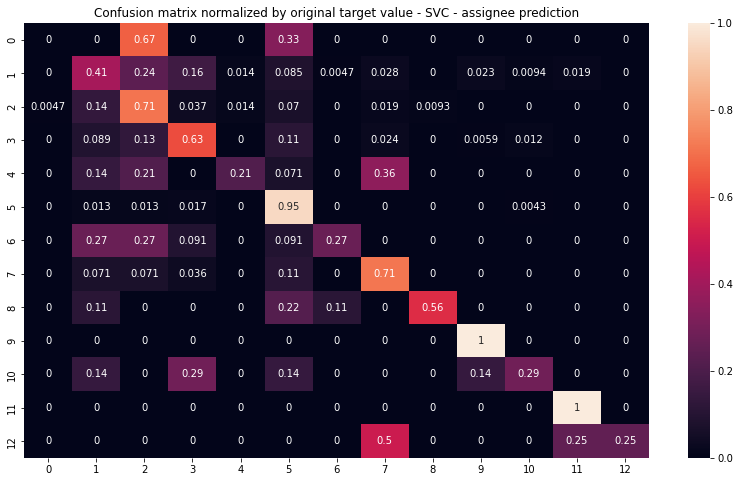

In [86]:
plt.figure(figsize=(14,8))
sns.heatmap(confusion_matrix(y_test,y_pred_rfc,normalize='true'),annot=True)
plt.title('Confusion matrix normalized by original target value - SVC - assignee prediction')

#### Text Embedding and LSTM 

In [87]:
# one hot representation of words in text in specified vocabulary size

from tensorflow.keras.preprocessing.text import one_hot

vocab_size=50000
onehot_repr=[one_hot(words,vocab_size) for words in Text]

onehot_repr[0]

[21796,
 34099,
 7265,
 28745,
 21796,
 4012,
 27089,
 29757,
 36286,
 40686,
 36286,
 47876,
 26708,
 42347,
 7265,
 2395,
 26350,
 46781,
 31863,
 5807,
 36958,
 44753,
 29366,
 27444,
 46715,
 20123,
 20123,
 20123]

In [88]:
# Padding(pre) on one hot represented data

from tensorflow.keras.preprocessing.sequence import pad_sequences

sent_len=150
padded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_len) # padding to equalize all doc/sentences' length

print(padded_docs.shape)
padded_docs

(4683, 150)


array([[    0,     0,     0, ..., 20123, 20123, 20123],
       [    0,     0,     0, ..., 20123, 20123, 20123],
       [    0,     0,     0, ..., 20123,  4332, 20123],
       ...,
       [    0,     0,     0, ..., 20123,  4332, 20123],
       [    0,     0,     0, ..., 20123,  4332, 20123],
       [    0,     0,     0, ..., 20123,  4332, 20123]])

In [89]:
# Just to see if embedding working fine on data and how it looks after embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM


embedding_size=6
model_embd=Sequential()
model_embd.add(Embedding(input_dim=vocab_size,output_dim=embedding_size,input_length=sent_len))

model_embd.compile(optimizer='adam',loss='categorical_crossentropy')

embedded_docs=model_embd.predict(padded_docs)

print(embedded_docs.shape)
embedded_docs 

(4683, 150, 6)


array([[[-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        [-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        [-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        ...,
        [-0.04225326,  0.04087974,  0.04162425, -0.02582661,
          0.03262893,  0.0095442 ],
        [-0.04225326,  0.04087974,  0.04162425, -0.02582661,
          0.03262893,  0.0095442 ],
        [-0.04225326,  0.04087974,  0.04162425, -0.02582661,
          0.03262893,  0.0095442 ]],

       [[-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        [-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        [-0.00040545,  0.02403778, -0.03885581,  0.01300088,
          0.0103805 , -0.0232126 ],
        ...,
        [-0.04225326,  0.04087974,  0.04162425, -0.02582661,
          0.03262893,  0.0095442 ],
  

In [90]:
print(padded_docs[0])
print(embedded_docs[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0 21796 34099  7265 28745 21796  4012 27089 29757 36286 40686
 36286 47876 26708 42347  7265  2395 26350 46781 31863  5807 36958 44753
 29366 27444 46715 20123 20123 20123]
[[-4.05453146e-04  2.40377821e-02 -3.88558134e-02  1.30008794e-02
   1.03804953e-02 -2

(3746, 150) (3746,)
(937, 150) (937,)


C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Assignee')

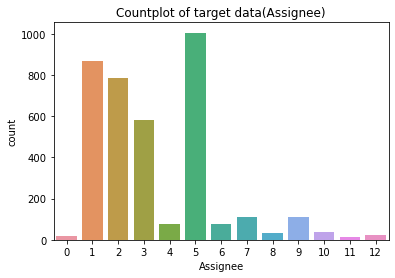

In [91]:
# Train test split of padded data 

X_finalL=np.array(padded_docs)
Y_finalL=np.array(Y)


x_trainL,x_testL,y_trainL,y_testL=train_test_split(X_finalL,Y_finalL,train_size=0.8,random_state=42)

print(x_trainL.shape,y_trainL.shape)
print(x_testL.shape,y_testL.shape)

sns.countplot(y_trainL)
plt.title('Countplot of target data(Assignee)')
plt.xlabel('Assignee')

##### From above countplot, it is clear that data is imbalanced, to oversampling to be performed

(13078, 150) (13078,)


C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Assignee')

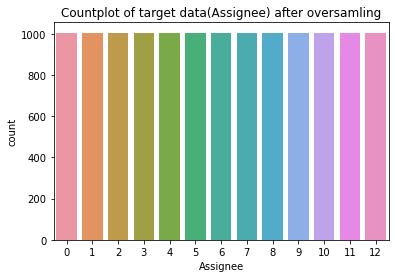

In [92]:
smt_LSTM=SMOTE(random_state=42)
x_trainL_res,y_trainL_res=smt_LSTM.fit_resample(x_trainL,y_trainL)

print(x_trainL_res.shape,y_trainL_res.shape)
sns.countplot(y_trainL_res)
plt.title('Countplot of target data(Assignee) after oversamling')
plt.xlabel('Assignee')

In [93]:
pd.Series(y_trainL_res).unique()

array([ 2,  3,  5,  1,  8,  7,  9,  6,  4, 12, 11,  0, 10], dtype=int64)

#### LSTM

In [94]:
# Creating Deep learning model by embedding ,LSTM, Dense layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense
model_LSTM_prdctAssgne=Sequential()
model_LSTM_prdctAssgne.add(Embedding(input_dim=vocab_size,output_dim=embedding_size,input_length=sent_len))
model_LSTM_prdctAssgne.add(LSTM(100))
model_LSTM_prdctAssgne.add(Dense(units=1,activation='softmax'))


model_LSTM_prdctAssgne.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

print(model_LSTM_prdctAssgne.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 6)            300000    
                                                                 
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 342,901
Trainable params: 342,901
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
# Traning sequential model 

model_LSTM_prdctAssgne.fit(x_trainL_res,y_trainL_res,epochs=10,batch_size=1000,validation_data=(x_testL,y_testL))

Epoch 1/10
14/14 [==============================] - 28s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 2/10
14/14 [==============================] - 23s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 3/10
14/14 [==============================] - 22s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 4/10
14/14 [==============================] - 23s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 5/10
14/14 [==============================] - 23s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 6/10
14/14 [==============================] - 23s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss: 0.0000e+00 - val_accuracy: 0.2273
Epoch 7/10
14/14 [==============================] - 23s 2s/step - loss: 0.0000e+00 - accuracy: 0.0769 - val_loss

In [96]:
y_predL=model_LSTM_prdctAssgne.predict(x_testL)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.23      1.00      0.37       213
           2       0.00      0.00      0.00       214
           3       0.00      0.00      0.00       169
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00       234
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        29
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4

    accuracy                           0.23       937
   macro avg       0.02      0.08      0.03       937
weighted avg       0.05      0.23      0.08       937



C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KrishnenduGhorui\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion matrix normalized by original target value-Deep learning model(LSTM)-Assignee prediction')

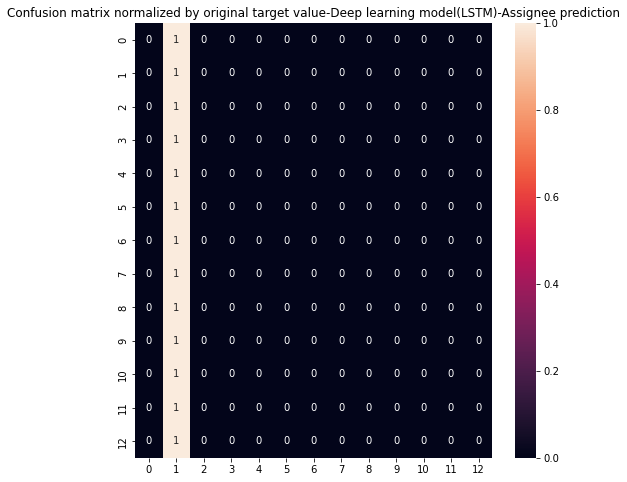

In [97]:
# Model performance evluation 

print(classification_report(y_testL,y_predL))
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_testL,y_predL,normalize='true'),annot=True)
plt.title('Confusion matrix normalized by original target value-Deep learning model(LSTM)-Assignee prediction')

##### So, Random Forest classifier model giving higher accuracy, so tha will be used for deployment

##### Dumping object to pickle for deployment purpose 

In [98]:
import pickle 

pickle.dump(model_rfc,open('model_rfc.pkl','wb'))
pickle.dump(model_mnb,open('model_mnb.pkl','wb'))
pickle.dump(le_Label,open('le_Label.pkl','wb'))
pickle.dump(le_Component,open('le_Component.pkl','wb'))
pickle.dump(vect_tfidf,open('vect_tfidf.pkl','wb'))